# Fast Transient Searches

Author: Igor Andreoni <br>
Contact: andreoni@umd.edu <br>
ZTF Summer School 2022

### Objective
The objective of this notebook is to learn how to mine a large dataset for (rare) extragalactic fast transient sources.

### Introduction
Wide-field surveys like the Zwicky Transient Facility (ZTF) image the entire observable sky almost every night multiple times. This makes ZTF as excellent instrument for time-domain astronomy. Image subtraction between a new "science" image and a deep "reference" (or "template") image makes every new source, or every source that changes in luminosity, stand out. When such a source is identified in a new image, an alert packet is issued, which is a dictionary rich with information, including differential photometry between the science and the template images.

ZTF issues about 300,000 alerts every night. Searching for extragalactic fast transients constitutes a "needle in the haystack" big data challenge.

### Method
A data set (see below) is provided which is very similar to the stream of alerts that ZTF issues in one night. The amount of alerts is in the order of ~100k, which is a number large enough to make it unsustainable for a human to check each source individually on a daily basis. The objective of the notebook is to apply a number of well-motivated cuts to bring an overwhelming amount of information down to a manageable number of transients that astronomers can vet. The main steps will be:
- read and understand the data
- plot light curves
- apply cuts progressively
- when < 10 candidates are left, inspect them in detail


### The data set
Two data files were prepared for this school activity, both in JSON format. JSON files are, essentially, dictionaries.

The alerts were all issued on the night of 2021-02-05 UT. The total number of alerts issued on that night approximated 1 million. If all the alerts were to be used, complete with all their entries, they total disk space for the 2021-02-05 night is larger than 16GB. To facilitate the download and handling of the data, alerts were selected that:
- have at least 2 detections for the source (ndethist >= 2)
- are likely real according to two real/bogus classifiers (drb > 0.8; braai > 0.8)
- left a positive residual after image subtraction, i.e. the flux in the science image is larger than in the template image (warning: the source might have been fainter than the template in a past science image, generating a "negative" subtraction!)

The data files are `data/fast_transient_alerts.json` for the alerts, `data/fast_transient_lc.json` for the light curves.

- `data/fast_transient_alerts.json` Uniform JSON file (readable as a table using `pandas`) containing a selection of relevant information from the original alerts.
- `data/fast_transient_lc.json` Light curves. The light curve of some transients have thousands of data points. To keep the data set manageable and our eyes on the scientific objective to discover fast transients, some of the light curves were cut. In particular, **empty light curves** were assigned to those transients that:
    - have at least one "negative" subtraction in the past (see above)
    - are located at Galactic latitude `-8 deg < b < +8 deg` <br>
In addition, only those data points within the last 30 days before the alert was issued are present in the light curves. Long-duration transients, variables, and repeatingly bursting sources are outside the scope of this activity. However, data points acquired after the last alert included in the `fast_transient_alerts.json` file will be present. 
    
### Requirements
* python 3
* numpy, pandas, matplotlib, astropy, collections

### Useful links
[ZTF Avro schema for the alerts](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html)<br>
[Public ZTF alerts](https://ztf.uw.edu/alerts/public/)<br>
[Alert brokers for ZTF and Rubin Observatory](https://www.lsst.org/scientists/alert-brokers)

## Import python packages

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

## Read and understand the data

Read the data file. Beware that this action could take several minutes. The alerts JSON file is uniform and can be read as a `pandas` data frame.

In [2]:
# Open the file with the alerts
alerts_filename = "data/fast_transient_alerts.json"
df_alerts = pd.read_json(alerts_filename)
# To have one alert per row instead of column, use transpose()
df_alerts = df_alerts.transpose()

In [7]:
# Open the file with the light curves
lc_filename = "data/fast_transient_lc.json"
  
# Opening JSON file
f = open(lc_filename)
  
# returns JSON object as a dictionary
lc_dict = json.load(f)

What do the data look like? It is a good idea to see what the data variables include, but we have to be careful about printing such a large amount of information all at once. Exploring the length of what we are going to print first is recommended.

In [8]:
# How many alerts do we have?
len(df_alerts)

106560

In [9]:
# What is the name of the alerts data frame columns?
df_alerts.columns

Index(['jd', 'fid', 'isdiffpos', 'rcid', 'ra', 'dec', 'magpsf', 'sigmapsf',
       'rb', 'ssdistnr', 'srmag1', 'sgscore1', 'distpsnr1', 'ndethist',
       'jdstarthist', 'jdendhist', 'srmag2', 'sgscore2', 'distpsnr2', 'srmag3',
       'sgscore3', 'distpsnr3', 'drb', 'objectId'],
      dtype='object')

**STOP**. What do these column names mean? In order to use them in a smart way, check them out in the [ZTF Avro schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html)

In [10]:
#What do alerts look like, in this short version?
df_alerts[0:3]

,jd,fid,isdiffpos,rcid,ra,dec,magpsf,sigmapsf,rb,ssdistnr,...,jdstarthist,jdendhist,srmag2,sgscore2,distpsnr2,srmag3,sgscore3,distpsnr3,drb,objectId
601cb75947230767c903ce48,2459250.626065,1,t,45,41.706031,-22.509571,15.914849,0.052548,0.512857,-999.0,...,2458383.932454,2459250.626065,18.7122,1.0,11.778825,-999.0,0.5,15.36731,0.975172,ZTF18abyitqr
601cb758040c9a45b915243b,2459250.626065,1,t,52,46.59873,-20.729952,19.315357,0.187526,0.528571,-999.0,...,2458860.605127,2459250.626065,21.7882,0.906845,5.796002,21.646299,0.923917,13.633864,0.999086,ZTF20aafuwfv
601cb761da8192014092f81a,2459250.626065,1,t,4,46.82753,-27.066677,19.544296,0.215844,0.545714,-999.0,...,2459117.897257,2459250.626065,20.7647,0.005,23.80216,-999.0,-999.0,-999.0,0.988304,ZTF20acekgfz


Let's warm up with selection criteria for the alerts. For example, we can check if any one of the alerts has exactly 20 detections in its history, it is at least 5 arcsec away from the closest PS1 catalog source, and the closest PS1 cataloged source is likely a galaxy. Remember that the star/galaxy classification goes from 0 (likely galaxy) to 1 (likely star).

In [15]:
crit_test = (df_alerts['ndethist'] == 20) & (df_alerts['distpsnr1'] > 5) & (df_alerts['sgscore1'] < 0.5)
df_alerts[crit_test]["objectId"]

601cfaac6fbae9e71c9bcabe    ZTF21aagnvvk
601d038d6fbae9e71c9bd805    ZTF21aagmryd
Name: objectId, dtype: object

Let's display a light curve. For example, the dataset includes ZTF21aagnvvk, which is a Type Ia supernova that was assigned IAU name [AT2021bnf](https://www.wis-tns.org/object/2021bnf). You should have found this transient using the selection criteria in the cell above.

To make things easier, the filter id (`fid`) column was replaced with the `filter` name (g, r, or i) column. Note that upper limits from non-detections are not included in this data set, so you will find only information about detections, even if knowing the last non-detection time of a transient can be crucial to constrain its onset.

In [17]:
lc_dict["ZTF21aagnvvk"]

[{'jd': 2459232.78481, 'magpsf': 20.856, 'sigmapsf': 0.371, 'filter': 'g'},
 {'jd': 2459232.88103, 'magpsf': 20.705, 'sigmapsf': 0.269, 'filter': 'g'},
 {'jd': 2459232.92484, 'magpsf': 20.591, 'sigmapsf': 0.286, 'filter': 'g'},
 {'jd': 2459233.77119, 'magpsf': 20.487, 'sigmapsf': 0.273, 'filter': 'r'},
 {'jd': 2459248.75645, 'magpsf': 19.06, 'sigmapsf': 0.11, 'filter': 'g'},
 {'jd': 2459248.76622, 'magpsf': 19.032, 'sigmapsf': 0.09, 'filter': 'g'},
 {'jd': 2459248.75551, 'magpsf': 19.082, 'sigmapsf': 0.104, 'filter': 'g'},
 {'jd': 2459248.86705, 'magpsf': 18.948, 'sigmapsf': 0.104, 'filter': 'r'},
 {'jd': 2459248.88325, 'magpsf': 18.924, 'sigmapsf': 0.094, 'filter': 'r'},
 {'jd': 2459248.90036, 'magpsf': 19.016, 'sigmapsf': 0.113, 'filter': 'g'},
 {'jd': 2459248.88231, 'magpsf': 19.025, 'sigmapsf': 0.094, 'filter': 'r'},
 {'jd': 2459248.93757, 'magpsf': 19.023, 'sigmapsf': 0.11, 'filter': 'r'},
 {'jd': 2459249.79897, 'magpsf': 19.158, 'sigmapsf': 0.28, 'filter': 'r'},
 {'jd': 2459249.8

## Plot a light curve
Define a function to plot the light curve of a given transient

In [37]:
def plot_lc(name):
    """
    Plot a light curve given a ZTF transient name.
    Assume lc_dict to be a global variable already defined.

    Parameters
    ----------
    name str
        name (objectId) of the ZTF transient
    """
    # Get the lc of interest
    lc = lc_dict[name]
    # What are the filters in which it was observed
    filters = [x["filter"] for x in lc]
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize = (15,10))
    
    # Plot the light curve in each filter
    for f in set(filters):
        time = [x["jd"] for x in lc if x['filter'] == f]
        mag = [x['magpsf'] for x in lc if x['filter'] == f]
        magerr = [x['sigmapsf'] for x in lc if x['filter'] == f]
        ax.errorbar(time, mag, yerr=magerr, marker="o", label=f)
    # Legend without repeatitions
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid()
    # Axes name
    ax.set_xlabel("Time (in jd)")
    ax.set_ylabel("Magnitude")
    ax.set_title(name)
    
    # Note: smaller magnitude means larger luminosity!
    ax.set_ylim(ax.get_ylim()[::-1])

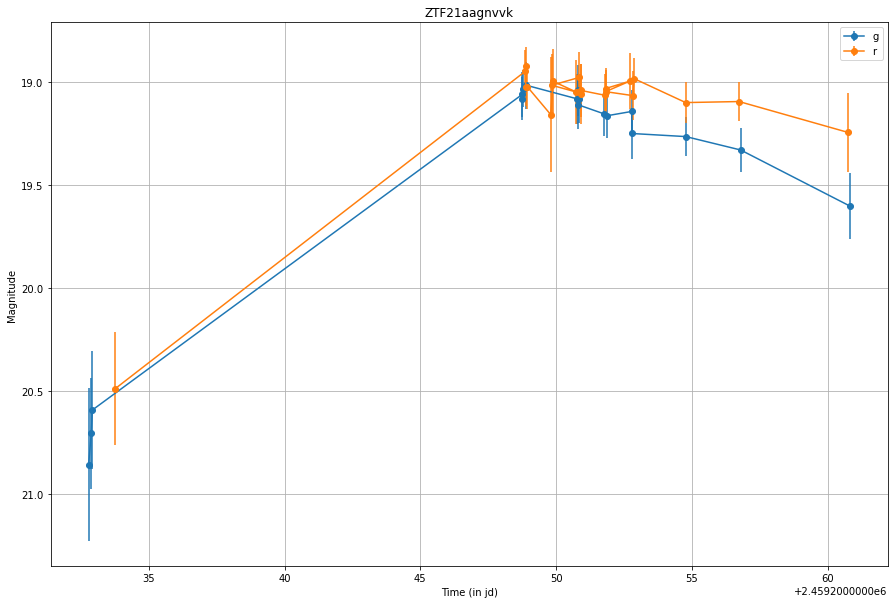

In [38]:
# Try out the new function ZTF21aagnvvk
plot_lc("ZTF21aagnvvk")

Bonus quiz: Now try out the plotting function on ZTF21aagmryd. Can you guess which type of supernova this is ONLY based on the light curve?

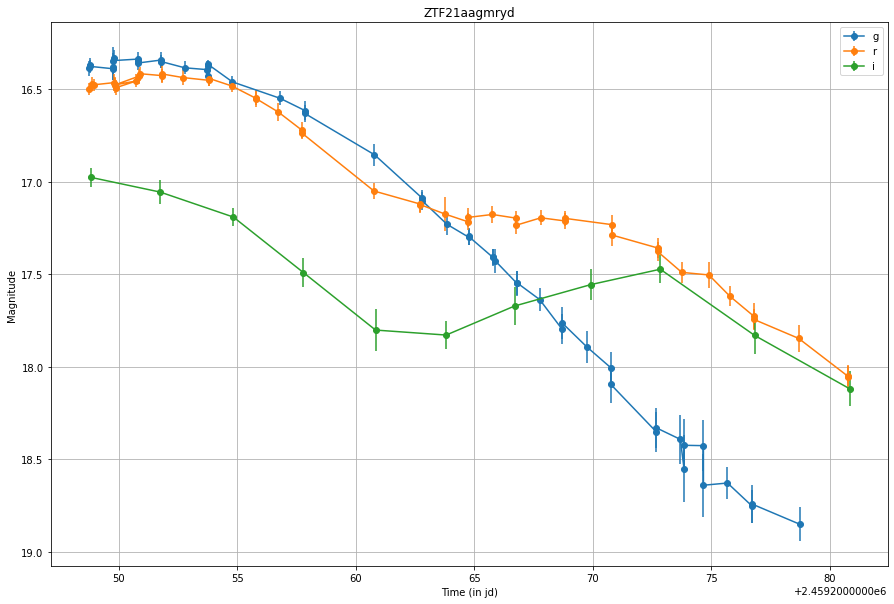

In [39]:
plot_lc("ZTF21aagmryd")

# Fast transient quest

Now the real search for fast transients begins!

## Moving objects

<img src="Figures/figure_asteroid.jpg" alt="drawing" width="500"/>

Objects that move in the sky significantly in little time are likely asteroids or other types of natural (or artificial) near-Earth objects. Those must be removed from the sample. 

The ZTF alerts include valuable information such as the distance to the nearest catalogued solar system objects (`ssdistnr`). How many alerts fall within 10 arcsec from a catalog solar system object? Note: if no match is found, `ssdistnr == -999`

In [40]:
crit_moving = (df_alerts["ssdistnr"] < 10) & (df_alerts["ssdistnr"] > 0)
len(df_alerts[crit_moving])

808

In [41]:
# Now define a criterion to EXCLUDE those moving objects
crit_nomoving = ~crit_moving

This is good, but probably not enough to exclude all the moving objects. Some may be uncataloged, and others might not be precisely localized. Another effective way to remove moving objects is to set a minimum time gap between the first and the last detection of a transient. Usually, asteroids move > 1 arcsec every 15 minutes. Our target transients (kilonovae, GRB afterglows) evolve in minutes to days time scales, so we can afford to set a minimum time gap of 30 minutes, for extra safety.

To build this criterion, we can use the `jd` and the `jdstarthist` keys present in every alert. 

In [49]:
crit_mingap = (df_alerts["jd"] - df_alerts["jdstarthist"] > 0.5/24)
len(df_alerts[crit_mingap])

89942

Putting the no-moving criteria together, what fraction of alerts remains?

In [50]:
len(df_alerts[crit_nomoving & crit_mingap])/len(df_alerts)

0.8430930930930931

## Stellarity
“Dwell on the beauty of life. Watch the stars, and see yourself running with them.” <br>
― Marcus Aurelius, Meditations

“Dwell on the beauty of life. Watch the stars, and see yourself running away from them.” <br>
― Extragalactic Astronomers

<img src="Figures/figure_stellarity.png" alt="drawing" width="400"/>

The star/galaxy classifier can help us remove stellar sources from the sample. As mentioned before, the star/galaxy classification goes from 0 (likely galaxy) to 1 (likely star). We can wonder: 
- is the location of the transient coincident with the location of a catalogued source?
- is the closest source likely a star or a galaxy?

A combination of `sgscore1` and `distpsnr1` will answer both questions. Remember that the PSF of the ZTF camera has FWHM ~ 1 arcsec and the seeing at Palomar Observatory is often 1.0-1.5 arcsec.

In [51]:
crit_stellar = (df_alerts["sgscore1"] > 0.5) & (df_alerts["distpsnr1"] < 2.5) & (df_alerts["distpsnr1"] >= 0)
crit_nostellar = ~crit_stellar

What fraction of alerts are likely generated by stellar sources? (Imagine what this fraction would be if we included also those sources with Galactic latitude |b| < 8 deg)

In [ ]:
len(...)/...

Bonus: plot the light curve of the star with most detections among those never brighter than 17 mag in any band.

In [ ]:
...

## Total duration
We are interested in fast transients, but what this means is somewhat ambiguous. However, if we think of electromagnetic counterparts to gravitational waves, we expect them to remain bright (for a given detection limit) for a few days, perhaps weeks but only for exceptionally nearby or bright cases.

Bonus quiz: assuming that ZTF has a limitng magnitude of ~20.5 mag, how long would a GW170817-like kilonova be detectable in g and r band? What if it was located at 120 Mpc instead of 41 Mpc?

In [ ]:
# Set a threshold for the duration
max_duration = ...
crit_maxduration = (... < max_duration)
len(df_alerts[crit_maxduration])

**Note:** The light curves put together for this notebook contain data points that were acquired even **after** the last alert present in the datafile. Therefore some transients pass the total duration criterion, but their light curve plot will show a long-duration transient. Building a criterion based on the light curves rather than on the alerts would yield an even better selection.

## Put together the selection criteria
How many alerts are left when the criteria for moving objects, stellarity, and duration are put together? How many transients? What is the fraction of sources that were discarded in the process?

In [ ]:
df_alerts_select = df_alerts[crit_nomoving & ... & ... & ...]
print("Number of alerts left:", len(df_alerts_select))
print("Number of transients that pass the cuts:", ...) # remember objectId
# Discarded sources
n_tot_sources = len(set(df_alerts["objectId"]))
n_select_sources = len(set(df_alerts_select["objectId"]))
fraction_discarded = (...)/n_tot_sources
print("Fraction of discarded sources:", fraction_discarded)

This is very good, but is it good enough? Is this sustainable for daily scanning/vetting by humans? It is doable, but we can do better.

## Light curve evolution
We still have a powerful tool that we can use: the rate at which the luminosity changes! The alerts present in the data set were all generated in one night, so we should move to the light curve data at this point.

In Python it is better to stay away from `for` loops, but since we have only a few hundreds of transients left, we can afford to iterate and analyze each light curve individually.

Before doing that, we must define a function that determines whether a light curve shall pass or not pass a given criterion on its evolution. To do things properly, we should consider a rising phase (typically faster) and a fading phase (typically slower) and/or fit models to the data (see, e.g., the methods used in the [ZTFReST](https://ui.adsabs.harvard.edu/abs/2021ApJ...918...63A/abstract) framework). We can build a simplified version of this algorithm.

In [ ]:
def evaluate_lc(name, thresh=0.3):
    """
    Evaluate if a light curve evolves fast enough
    Assume lc_dict to be a global variable already defined.

    Parameters
    ----------
    name str
        name (objectId) of the ZTF transient
    thresh float
        threshold for the evolution rate (mag/day)
    
    Returns
    -------
    selected bool
        if the transient fades faster than thresh
        in at least one band, returns True, otherwise False
    """
    # Initialize the variable to return
    selected = False
    # Individual light curve
    lc = lc_dict[name]
    # Iterate on the filters
    filters = ... # See the plot_lc function
    for f in set(filters):
        time = ...
        mag = ...
        magerr = ...
        # Condition for the rise/fade rate
        if np.abs(np.max(mag) - np.min(mag))/(time[np.argmax(mag)]-time[np.argmin(mag)]) > thresh:
            selected = True
            # No need to keep going if selected becomes True
            break
    
    return selected

Let's try it out. How many transients have a light curve that evolves faster than 0.5 mag/day?

In [ ]:
names_selected = []
for name in set(df_alerts_select["objectId"]):
    try:
        if evaluate_lc(name, ...) is True:
            names_selected.append(name)
    except KeyError:
        print(f"{name} not present in light curve file, ignore")
print("Number of sources to vet:", len(names_selected))

In [ ]:
names_selected

Plot the light curves and complete the candidate vetting on [Fritz](https://fritz.science). which one of the selected transients is most likely a genuine extragalactic fast transient?

In [ ]:
plot_lc(...)

In [ ]:
plot_lc(...)

# Epilogue

Epilogue to be read in the `fast_transients_solutions.ipynb` notebook!